## XGBoost Application

After tuning hyperparameters, I retrain the model on these parameters for the whole dataset. Then, I create visualization on model performance and feature importance (both global and local/SHAP)

In [1]:
#import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#preprocessing tools
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder

#models
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

#metrics
from sklearn.metrics import balanced_accuracy_score, make_scorer, mean_squared_error
from sklearn.inspection import permutation_importance

#visualizations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import shap
shap.initjs() # required for visualizations later on

In [2]:
#read in data set and print
df = pd.read_csv('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/data/data_edit2.csv', delimiter=',')
df.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,NITtime,PVHtime,CVHtime,voc_fake,voc_conf,extraver,agreeable,conscient,neuroticism,openness
0,2.0,4.0,4.0,5.0,5.0,5.0,3.0,2.0,2.0,4.0,...,6799.0,12788.0,7297.0,1,11,8.0,7.0,11.0,7.0,6.0
1,4.0,4.0,3.0,4.0,5.0,2.0,5.0,5.0,2.0,4.0,...,7035.0,6411.0,7910.0,0,10,6.0,10.0,7.0,8.0,6.0
2,4.0,2.0,3.0,2.0,4.0,2.0,4.0,1.0,2.0,2.0,...,8907.0,15823.0,6442.0,0,8,6.0,6.0,8.0,7.0,4.0
3,5.0,5.0,1.0,3.0,5.0,5.0,5.0,5.0,3.0,1.0,...,8994.0,27609.0,6739.0,0,8,5.0,5.0,8.0,10.0,2.0
4,2.0,4.0,2.0,2.0,2.0,2.0,4.0,4.0,1.0,2.0,...,12294.0,4149.0,8038.0,0,10,9.0,10.0,7.0,5.0,5.0


In [3]:
df = df.loc[:, df.columns != 'major'] #remove major column (no time to process with regex)
y1 = df.loc[:,'married']
X1 = df.loc[:, df.columns != 'married'] # all other columns are features  

# FOR USE IN XGBOOST
print(type(y1))
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y1)
label_encoded_y = pd.Series(label_encoder.transform(y1))
print(type(label_encoded_y))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Preprocessing

In [4]:
#DETERMINE ENCODERS
#most everything is already encodeded and bounded in a range
#categorical - questions that are answered on likert
onehot_ft = ['race', 'voted','familysize','urban', 'gender', 'engnat', 'orientation','hand', \
             'religion','voc_fake', 'voc_conf']
minmax_ft = ['Mscore', 'age','Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A', 'Q7A', 'Q8A', \
             'Q9A', 'Q10A','Q11A', 'Q12A', 'Q13A', 'Q14A','Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A', 'Q20A',\
             'education', 'extraver', 'agreeable', 'conscient', 'neuroticism', 'openness']                
stnd_ft = ['testelapse','PITtime', 'NITtime', 'PVHtime','CVHtime']    

In [5]:
# collect all the encoders
preprocess = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ft),
        ('minmax', MinMaxScaler(), minmax_ft),
        ('std', StandardScaler(), stnd_ft)
    ])

clf = Pipeline(steps=[('preprocessor', preprocess)])

### Model Implementation

##### Define XGBoost Classifier

In [6]:
# Init classifier
xgb_cl = xgb.XGBClassifier(eval_metric =  'mlogloss',#balanced_accuracy_score,
                           max_depth = 30,
                           learning_rate = 0.05,
                           reg_alpha = 0,
                           reg_lambda = 0,
                           use_label_encoder = False,
                           num_class = 3,
                           random_state=31)

##### Split and Fit Data

In [7]:
''' stratified kfold splitting: xgboost with tuned hyperparameters'''

test_scores_xgb = []
X_test_ar = []
y_test_ar = []
#for confusion matrix
preds_ar = []

#init splitter
splitter = StratifiedKFold(n_splits=4,shuffle=True, random_state = 42)

for i, (train_index, other_index) in enumerate(splitter.split(X1, label_encoded_y)):
    #random_state = i #change random states
    #split into train and other
    X_train, X_other = X1.iloc[train_index], X1.iloc[other_index]
    y_train, y_other = label_encoded_y[train_index], label_encoded_y[other_index]
    
    for val_index, test_index in splitter.split(X_other,y_other):
        X_val, X_test = X1.iloc[val_index], X1.iloc[test_index]
        y_val, y_test = label_encoded_y[val_index], label_encoded_y[test_index]
        
        #apply transformer
        X_train_prep = preprocess.fit_transform(X_train)
        X_val_prep = preprocess.transform(X_val)
        X_test_prep = preprocess.transform(X_test) 
        
        #collect features names after the preprocessing
        feature_names = list(clf.named_steps['preprocessor'].transformers_[0][1].get_feature_names(onehot_ft)) + \
        clf.named_steps['preprocessor'].transformers_[1][-1] + clf.named_steps['preprocessor'].transformers_[2][-1]
    
    #append values
    X_test_ar.append(X_test)
    y_test_ar.append(y_test)

    # Fit
    evaluated_on=[(X_train_prep,y_train), (X_val_prep,y_val)]
    xgb_cl.fit(X_train_prep,y_train, 
               eval_metric=["merror", "mlogloss"], 
               early_stopping_rounds=60, 
               eval_set = evaluated_on,
               verbose = False)
    # Predict
    preds = xgb_cl.predict(X_test_prep)
    preds_ar.append(preds)

    test_scores_xgb.append(balanced_accuracy_score(y_test, preds))
    print('test results balanced accuracy', balanced_accuracy_score(y_test, preds))

test results balanced accuracy 0.8568412946931909
test results balanced accuracy 0.8504989702170428
test results balanced accuracy 0.866712128507617
test results balanced accuracy 0.8631540510836673


In [8]:
print('Balanced Accuracy:',np.around(np.mean(test_scores_xgb),2),'+/-',np.around(np.std(test_scores_xgb),2))

Balanced Accuracy: 0.86 +/- 0.01


In [185]:
#fraction of data in each set
print(len(y_val)/len(label_encoded_y))
print(len(y_test)/len(label_encoded_y))
print(len(y_train)/len(label_encoded_y))

0.18751200030720785
0.062478399447025844
0.7500096002457662


In [306]:
# save the output to be used later
import pickle
file = open('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/results/final_model.save', 'wb')
pickle.dump((xgb_cl, splitter, test_scores_xgb),file)
file.close()

### Accuracy Visualization (confusion matrix)

Text(0.5, 1.0, 'Confusion Matrix: Balanced Accuracy')

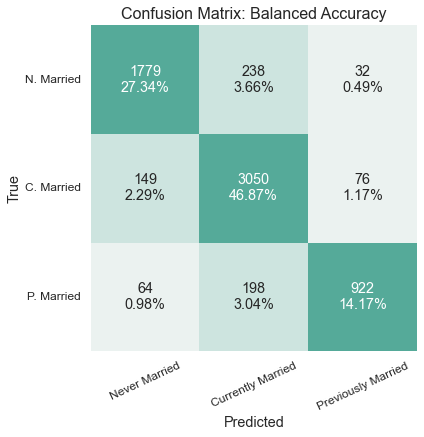

In [236]:
#CONFUSION MATRIX
#get the confusion matrix for last split and generate matrix
######preds = xgb_cl.predict(X_test_prep)
cm_xgb = confusion_matrix(np.ravel(y_test_ar),np.ravel(preds_ar))
color_choice = sns.color_palette("light:#5A9")#color pallette 

#get the counts, percentages each is to the whole dataset as labels
group_counts = ["{0:0.0f}".format(value) for value in
                cm_xgb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_xgb.flatten()/np.sum(cm_xgb)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)] 
labels = np.asarray(labels).reshape(3,3) #group labels in dimension of matrix

#crete heatmap/confusion matrix
plt.figure(figsize = (6,6))
sns.set(font_scale=1.2)
plot_grid = sns.heatmap(cm_xgb,
                        annot=labels,
                        fmt='', 
                        vmin=0, vmax=800,
                        square = True, 
                        cmap= color_choice , 
                        cbar = False)



#generate marriage cat. labels 
tick_labels = ['Never Married', 'Currently Married', 'Previously Married'] 
ytick_labels = ['N. Married', 'C. Married', 'P. Married'] 
#0 = never married , 1 = currently married, 2=previously married
plot_grid.set_xticklabels(tick_labels, fontsize = 12) #tick labels 
plot_grid.set_yticklabels(ytick_labels, fontsize = 12) #tick labels
plot_grid.set_ylabel("True")#, fontsize = 12) #x axis
plot_grid.set_xlabel("Predicted") #y axis
plt.xticks(rotation=25) 
plt.yticks(rotation=0) 

plot_grid.set_title('Confusion Matrix: Balanced Accuracy', fontsize = 16)



In [10]:
#save figure
plt.savefig('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/figures/bal_acc_cfm.pdf')#save to folder

<Figure size 432x288 with 0 Axes>

### Feature Importances

First, I'm going to generate the global feature importances. Here we'll look at the three importances defined in xgboost.

https://datascience.stackexchange.com/questions/34209/xgboost-quantifying-feature-importances 

In [11]:
#feature importance from the xgboost model object
fimp_gain = xgb_cl.get_booster().get_score(importance_type='gain') #gain 
fimp_cover = xgb_cl.get_booster().get_score(importance_type='cover') #doesn't give you zero cols
fimp_weight = xgb_cl.get_booster().get_score(importance_type='weight') #doesnt give you zero cols


In [151]:
feature_names_edit =['Race Unknown','Asian', 'Arab', 'Black', 'Idg. Australian', 'Native American', 'White', 'Other', \
 'Voting Unknown', 'Voted last year', 'Has not voted last year', 'Family of 0', 'Family of 1', 'Family of 2',\
 'Family of 3', 'Family of 4', 'Family of 5', 'Family of 6', 'Family of 7', 'Family of 8', 'Family of 9', 'Family of 10', \
 'Family of 11','Family of 12', 'Family of 13','Family of 14','Family of 15', 'Family of 16','Family of 17', \
 'Unknown location', 'Rural childhood', 'Suburban childhood', 'Urban childhood', 'Unknown Gender', 'Male', 'Female', \
 'Other Gender', 'Unknown Native Language', 'Native English', 'Not Native English', 'Unknown Orientation', 'Heterosexual', \
 'Bisexual', 'Homosexual', 'Asexual', 'Other Sexuality', 'Unknown Handedness', 'Right Handed', 'Left Handed', 'Ambidextrous', \
 'Unknown Religion','Agnostic', 'Atheist', 'Buddhist', 'Catholic', 'Mormon', 'Protestant', 'Christian (other)', 'Hindu', \
 'Jewish', 'Muslim', 'Sikh', 'Other Religion', 'Fake Words Known: 0', 'Fake Words Known: 1', 'Fake Words Known: 2', 'Fake Words Known: 3',\
 'Words Known: 0', 'Words Known: 1', 'Words Known: 2', 'Words Known: 3', 'Words Known: 4', 'Words Known: 5', 'Words Known: 6', \
 'Words Known: 7', 'Words Known: 8', 'Words Known: 9','Words Known: 10', 'Words Known: 11', 'Words Known: 12', 'Words Known: 13',\
 'Words Known: 14', 'Words Known: 15', 'Words Known: 16','Machiavellian Score', 'Age', 'Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A',\
 'Q7A', 'Q8A', 'Q9A', 'Q10A', 'Q11A', 'Q12A', 'Q13A', 'Q14A', 'Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A', 'Q20A', 'Education', \
 'Extraversion', 'Agreeableness', 'Conscientioness', 'Neuroticism', 'Openness', 'Time Taken: Test', \
  'Time Taken: PIT', 'Time Taken: NIT', 'Time Taken: PVH', 'Time Taken: CVH'] 
#check to make sure names are in right order
print(feature_names_edit[62])
print(feature_names[62])
print(feature_names_edit[5])
print(feature_names[5])
print(feature_names_edit[100])
print(feature_names[100])
print(feature_names_edit[31])
print(feature_names[31])
print(feature_names_edit[83])
print(feature_names[83])
print(feature_names_edit[19])
print(feature_names[19])

Other Religion
religion_12
Native American
race_50
Q15A
Q15A
Suburban childhood
urban_2
Words Known: 16
voc_conf_16
Family of 8
familysize_8


In [285]:
#check to make sure that they're the same length
print(len(fimp_gain) == len(edited_labels))
print(len(fimp_gain) == len(fimp_cover))
#fimp_gain #length = 117

False
True


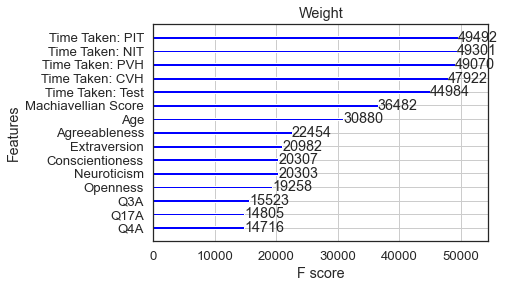

In [294]:
#FEATURE IMPORTANCE: WEIGHT
#get the feature names in the same format as xgboost
mapper_w = {'f{0}'.format(i): v for i, v in enumerate(feature_names_edit)}
#use the new names to get the actual feature names instead of numbers
mapped_w = {mapper_w[k]: v for k, v in fimp_weight.items()}
xgb.plot_importance(mapped_w, color='blue', max_num_features = 15)
plt.title("Weight")
#save figure
plt.savefig('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/figures/weight_imp_bar.pdf')#save figure

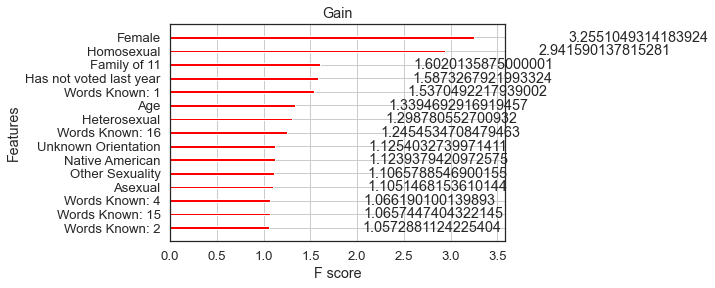

In [295]:
#FEATURE IMPORTANCE GAIN (copy pasted method from above)
mapper_g = {'f{0}'.format(i): v for i, v in enumerate(feature_names_edit)}
mapped_g = {mapper_g[k]: v for k, v in fimp_gain.items()}
xgb.plot_importance(mapped_g, color='red', max_num_features = 15)

plt.title("Gain")
#save figure
plt.savefig('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/figures/gain_imp_bar.pdf')#save figure

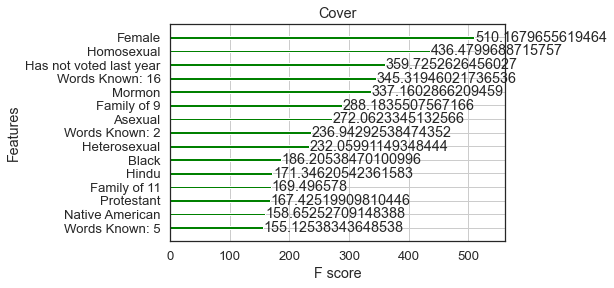

In [296]:
#FEATURE IMPORTANCE COVER (copy pasted method from above)
mapper_c = {'f{0}'.format(i): v for i, v in enumerate(feature_names_edit)}
mapped_c = {mapper_c[k]: v for k, v in fimp_cover.items()}
xgb.plot_importance(mapped_c, color='green', max_num_features = 15)

plt.title("Cover")
#save figure
plt.savefig('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/figures/cover_imp_bar.pdf')#save figure

Above we see lots of demographic variables with high influences. Below, the idea is to get all of the top 15 importances from each type of feature importance into a list of strings ordered by importance. Because the sorting is done in ascending order, the most important will be at the end of the dictionary. 

In [80]:
#create a sorted dictionary from the original dicitonary of mapped items & generate list from dictionary keys
sort_dict_w = {k: v for k, v in sorted(mapped_w.items(), key=lambda item: item[1])} #weighted
sort_dw = list(sort_dict_w.keys())[92:107] 

sort_dict_g = {k: v for k, v in sorted(mapped_g.items(), key=lambda item: item[1])} #gain
sort_dg = list(sort_dict_g.keys())[92:107]

sort_dict_c = {k: v for k, v in sorted(mapped_c.items(), key=lambda item: item[1])} #cover
sort_dc = list(sort_dict_c.keys())[92:107]

len((np.unique(sort_dw + sort_dg + sort_dc)))
#the max number of unique features is 45. The output 35 says which features 
#are important largely dependent on choice of method

35

In [81]:
#PERMUTATION IMPORTANCE
perm_imp = permutation_importance(xgb_cl, X_test_prep, y_test, n_repeats=10, random_state=0)
perm_imp['importances_mean']

array([ 6.14628150e-05, -7.37553780e-04,  0.00000000e+00,  2.76582667e-03,
        0.00000000e+00, -6.76090965e-04, -1.04486785e-03, -3.07314075e-04,
        0.00000000e+00, -4.91702520e-04,  3.04240934e-02,  1.84388445e-04,
       -3.68776890e-04,  4.30239705e-04, -9.21942225e-04, -6.14628150e-04,
       -5.53165335e-04,  1.22925630e-04, -6.14628150e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.76090965e-04, -2.33558697e-03,
       -3.68776890e-04,  0.00000000e+00, -1.04486785e-03,  5.56853104e-02,
        1.22925630e-04,  0.00000000e+00,  4.42532268e-03,  2.45851260e-04,
        6.76090965e-04,  1.18008605e-02,  1.84388445e-04,  5.59311616e-03,
       -6.14628150e-05, -5.53165335e-04,  6.14628150e-05, -7.99016595e-04,
       -2.45851260e-04, -4.91702520e-04,  0.00000000e+00, -4.30239705e-04,
       -1.22925630e-03,  

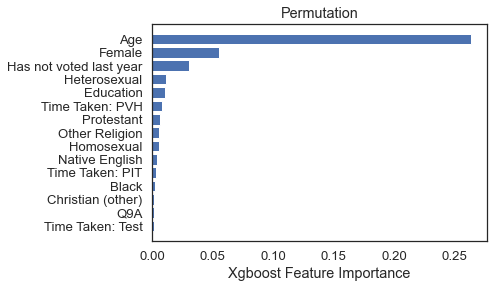

In [297]:
#sorted the indices of which ft importances are largest
sorted_idx = perm_imp['importances_mean'].argsort()
#print(sorted_idx)
ft_nm = np.asarray(feature_names_edit)
top20 = sorted_idx[102:len(ft_nm)] #collect the top 15

plt.barh(ft_nm[top20], perm_imp['importances_mean'][top20])
plt.xlabel("Xgboost Feature Importance")
plt.title("Permutation")
#save figure
plt.savefig('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/figures/permutation_imp_bar.pdf')#save figure

In [290]:
#generate similar list for permutation importance as with the other
perm_dc = list(ft_nm[top20])
len(np.unique(sort_dw + sort_dg + sort_dc + perm_dc))

40

In [287]:
#find the features that have no importance
list(set(feature_names_edit).difference(mapped_c))

['Unknown Gender',
 'Family of 12',
 'Unknown Native Language',
 'Family of 15',
 'Idg. Australian',
 'Family of 17',
 'Family of 16',
 'Family of 13',
 'Sikh',
 'Family of 14']

In [84]:
#CALCULATE RANK OF IMPORTANCE ACROSS DEMOGRAPHIC VS PERSONALITY
#lists of test & demographic variables
demo_ls =['Race Unknown','Asian', 'Arab', 'Black', 'Idg. Australian', 'Native American', 'White', 'Other', \
 'Voting Unknown', 'Voted last year', 'Has not voted last year', 'Family of 0', 'Family of 1', 'Family of 2',\
 'Family of 3', 'Family of 4', 'Family of 5', 'Family of 6', 'Family of 7', 'Family of 8', 'Family of 9', 'Family of 10', \
 'Family of 11','Family of 12', 'Family of 13','Family of 14','Family of 15', 'Family of 16','Family of 17', \
 'Unknown location', 'Rural childhood', 'Suburban childhood', 'Urban childhood', 'Unknown Gender', 'Male', 'Female', \
 'Other Gender', 'Unknown Native Language', 'Native English', 'Not Native English', 'Unknown Orientation', 'Heterosexual', \
 'Bisexual', 'Homosexual', 'Asexual', 'Other Sexuality', 'Unknown Handedness', 'Right Handed', 'Left Handed', 'Ambidextrous', \
 'Unknown Religion','Agnostic', 'Atheist', 'Buddhist', 'Catholic', 'Mormon', 'Protestant', 'Christian (other)', 'Hindu', \
 'Jewish', 'Muslim', 'Sikh', 'Other Religion', 'Age', 'Education']
          
surv_ls = ['Fake Words Known: 0', 'Fake Words Known: 1', 'Fake Words Known: 2', 'Fake Words Known: 3',\
 'Words Known: 0', 'Words Known: 1', 'Words Known: 2', 'Words Known: 3', 'Words Known: 4', 'Words Known: 5', 'Words Known: 6', \
 'Words Known: 7', 'Words Known: 8', 'Words Known: 9','Words Known: 10', 'Words Known: 11', 'Words Known: 12', 'Words Known: 13',\
 'Words Known: 14', 'Words Known: 15', 'Words Known: 16','Machiavellian Score', 'Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A',\
 'Q7A', 'Q8A', 'Q9A', 'Q10A', 'Q11A', 'Q12A', 'Q13A', 'Q14A', 'Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A', 'Q20A',  \
 'Extraversion', 'Agreeableness', 'Conscientioness', 'Neuroticism', 'Openness', 'Time Taken: Test', 
 'Time Taken: PIT', 'Time Taken: NIT', 'Time Taken: PVH', 'Time Taken: CVH']         

def imp_rank(ft_list):
    demo_sc = 0
    surv_sc = 0
    for i,v in enumerate(ft_list):
        if v in demo_ls:
            demo_sc += i
            #print('d',demo_sc)
        elif v in surv_ls:
            surv_sc += i
            #print('s',surv_sc)
    return  demo_sc, surv_sc

print(imp_rank(sort_dw))
print(imp_rank(sort_dc))
print(imp_rank(sort_dg))
print(imp_rank(perm_dc))
sum_dem = (imp_rank(sort_dw)[0] + imp_rank(sort_dc)[0] + imp_rank(sort_dg)[0] + imp_rank(perm_dc)[0])
sum_surv = (imp_rank(sort_dw)[1] + imp_rank(sort_dc)[1] + imp_rank(sort_dg)[1] + imp_rank(perm_dc)[1])
(sum_dem, sum_surv)

(8, 97)
(87, 18)
(85, 20)
(91, 14)


(271, 149)

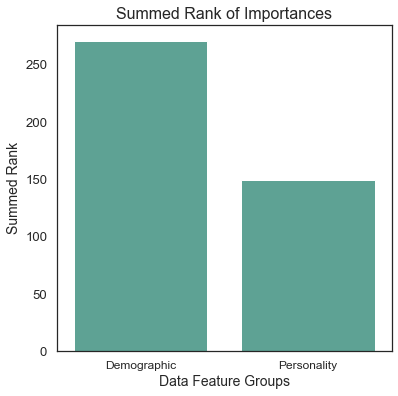

In [292]:
#BAR PLOT TO SHOW WHICH KIND OF VARIABLES ARE MOST IMPORTANT ACROSS IMPORTANCE TYPES
sns.set_theme(style="white")
df_pt = pd.DataFrame(data = [(0,(sum_dem)),
                             (1,(sum_surv))],
                             columns = ['Demographic', 'Personality'])

#crete heatmap/confusion matrix
plt.figure(figsize = (6,6))
sns.set(font_scale=1.2)
sns.set_style("white")
#sns.despine(offset=10, trim=True)

#crete scatter to compare ranks of ft importance
ax = sns.barplot(x="Demographic",
                 y="Personality", 
                 data=df_pt,
                 color=color_choice[5], 
                 saturation=0.8)

#generate labels, ticks, etc.
tick_labels = ["Demographic", "Personality"]
ax.set_xticklabels(tick_labels, fontsize = 12) #x labels 
ax.set_title('Summed Rank of Importances', fontsize = 16)
ax.set_xlabel("Data Feature Groups", fontsize = 14)
ax.set_ylabel("Summed Rank", fontsize = 14)

plt.savefig('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/figures/imp_summary_bar.pdf')#save figure

### Local Feature Importances 

In [165]:
# create the explainer object with the random forest model 
explainer = shap.TreeExplainer(xgb_cl)
#shap_values = explainer.shap_values(X_test_prep[:100])
all_shap_values = explainer.shap_values(X_test_prep, check_additivity=False)

In [24]:
# save the output to be used later
import pickle
file = open('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/results/shap_explainer.save', 'wb')
pickle.dump((explainer, shap_values),file)
file.close()

In [25]:
# pull the output from the file to be used
import pickle
file = open('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/results/shap_explainer.save','rb') 
explainer, multi_shap_values = pickle.load(file) 
file.close()

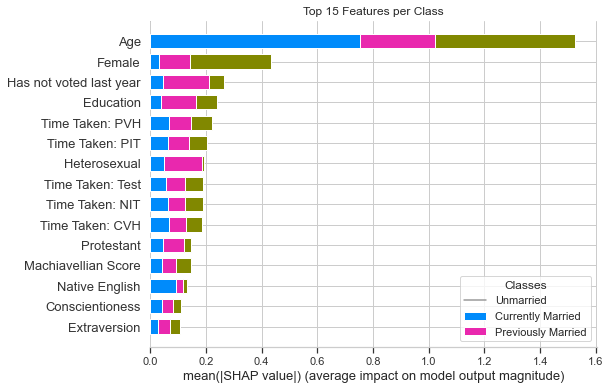

<Figure size 432x288 with 0 Axes>

In [291]:
# plot the distribution of importances for each feature over all samples
sns.set_theme(style="whitegrid")
greens = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

plt_shap = shap.summary_plot(all_shap_values, #Use Shap values array
                             features=X_test_prep, # Use training set features
                             feature_names=feature_names_edit, #Use column names
                             plot_size=(8,6),
                             max_display=15,
                             cmap = greens,
                             show=False) #Set to false to output to folder) # Change plot size

#labels
plt.title("Top 15 Features per Class")
plt.legend(title='Classes', loc='lower right', labels=['Unmarried', 'Currently Married','Previously Married'])
plt.show()

#save figure
plt.savefig('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/figures/shap_summary_bar.pdf')#save figure

In [175]:
index = 77# the index of the point to explain 
print(explainer.expected_value[0]) # we explain class 0 predictions 
print('Married Class point ', index )
shap.force_plot(explainer.expected_value[1], all_shap_values[1][index,:], features = feature_names_edit)

0.44234952
Married Class point  77


In [176]:
print('Unmarried Class point ', index )
shap.force_plot(explainer.expected_value[0], all_shap_values[0][index,:], features = feature_names_edit)

Unmarried Class point  77


In [177]:
print('Divorced Class point ', index )
shap.force_plot(explainer.expected_value[2], all_shap_values[2][index,:], features = feature_names_edit)

Divorced Class point  77


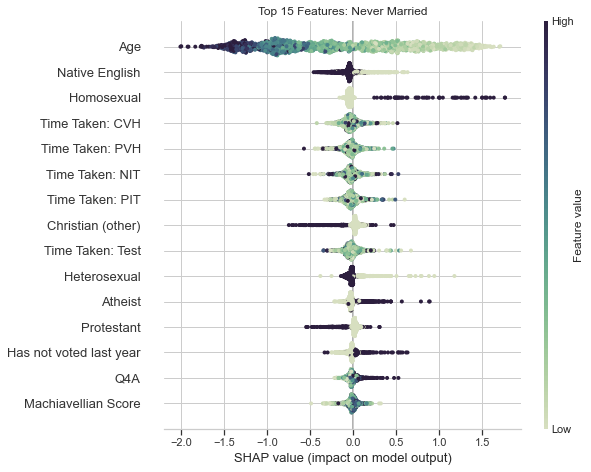

In [261]:
# plot the distribution of importances for each feature over all samples
sns.set_theme(style="whitegrid")
greens = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
shap.summary_plot(all_shap_values[0], 
                  X_test_prep, 
                  feature_names = feature_names_edit, 
                  max_display=15,
                  cmap = greens,
                  show=False)
#labels
plt.title("Top 15 Features: Never Married")
plt.show()

#save figure
plt.savefig('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/figures/shap_nmarried_scatter.pdf')#save figure

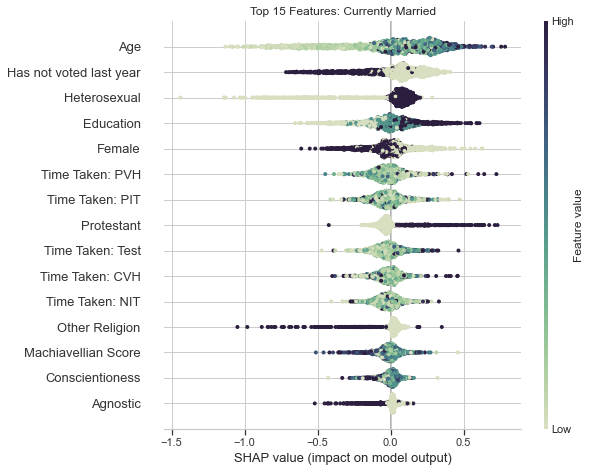

<Figure size 432x288 with 0 Axes>

In [304]:
# plot the distribution of importances for each feature over all samples
sns.set_theme(style="whitegrid")
shap.summary_plot(all_shap_values[1], 
                  X_test_prep, 
                  feature_names = feature_names_edit, 
                  max_display=15,
                  cmap = greens,
                  show=False)
#labels
plt.title("Top 15 Features: Currently Married")
plt.show()

#save figure
plt.savefig('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/figures/shap_cmarried_scatter.pdf')#save figure

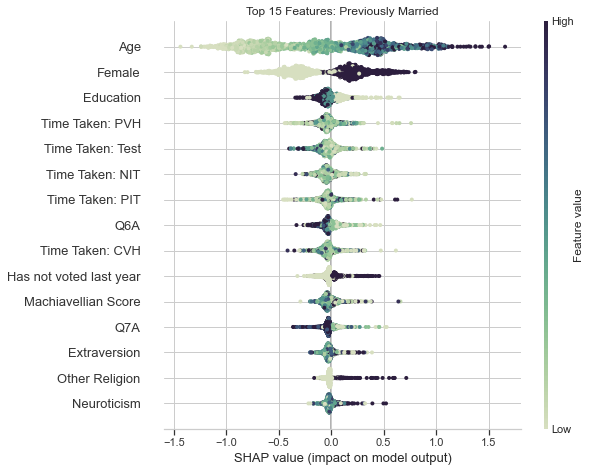

<Figure size 432x288 with 0 Axes>

In [305]:
# plot the distribution of importances for each feature over all samples
sns.set_theme(style="whitegrid")
shap.summary_plot(all_shap_values[2],
                  X_test_prep, 
                  feature_names = feature_names_edit, 
                  max_display=15,
                  cmap = greens,
                  show=False)
#labels
plt.title("Top 15 Features: Previously Married")
plt.show()

#save figure
plt.savefig('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/figures/shap_pmarried_scatter.pdf')#save figure

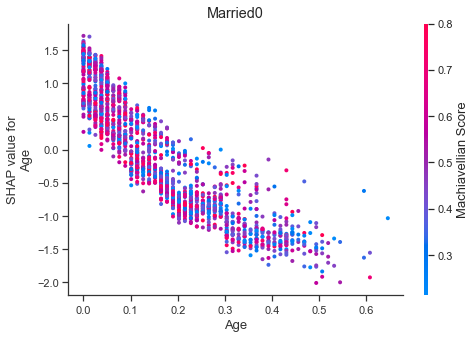

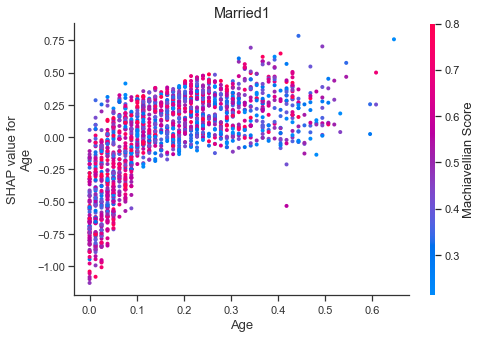

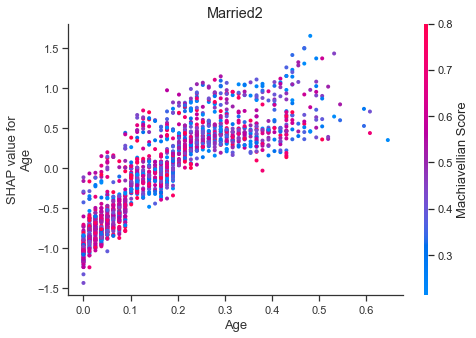

In [303]:
# plot the importance of a single feature across all samples
# make plots colored interacting features and predicted class
for i in [0,1,2]:
    shap.dependence_plot(85, 
                         all_shap_values[i], 
                         X_test_prep, 
                         feature_names=feature_names_edit,
                         interaction_index=84,
                         show = False)
    
    path = '/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/figures/age_mach{0}_scatter.pdf'.format(i)
    plt.title('Married{0}'.format(i)) #title
    plt.savefig(path)#save figure


XGBoost help 

https://towardsdatascience.com/20-burning-xgboost-faqs-answered-to-use-the-library-like-a-pro-f8013b8df3e4

Feature importance

https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost